# Install Transformers Library

In [1]:
import pandas as pd 


In [2]:
from google.colab import drive
#drive.mount('/content/gdrive/', force_remount=True)

isLocation = False

# path = '/content/gdrive/MyDrive/GTD/data_til_2010.csv'
# path = '/content/gdrive/MyDrive/GTD/data_1970_80.csv'
# path = '/content/gdrive/MyDrive/GTD/data_1981_95.csv'
# path = '/content/gdrive/MyDrive/GTD/data_96_2010.csv'
# path = '/content/gdrive/MyDrive/GTD/data_2011_12.csv'
# path = '/content/gdrive/MyDrive/GTD/data_2013_14.csv'
#path = '/content/gdrive/MyDrive/GTD/data_2015_17.csv'

In [3]:
!pip install transformers

In [4]:

def get_preprocess_data(originData):
  # originData = originData.rename(index=str, columns={'event id': 'eventid'})
  df = originData[originData['city'].notnull()] 
  # print("Columns before prepprocessing",len(df.columns))
  #df = df.loc[:,df.isnull().sum()/len(df) <0.30]
  # print("Columns after prepprocessing",len(df.columns))
  categorical = ['extended','crit1','crit2','crit3','doubtterr','alternative','alternative_txt','multiple','enc_country',\
               'country_txt','enc_region','region_txt','vicinity','specificity','enc_attacktype','attacktype','enc_weapon_type',\
               'weapon_type','enc_weapon_subtype','weapon_subtype','success','suicide','target_entity','enc_target','target_type',
               'target_subtype','enc_nationality','nationality','claimed','property','cross_border','ideological_international',\
               'province','entity','group','hostages/kidnapping','city','INT_MISC','INT_ANY','individual']
  

  df.rename(columns = {'iyear':'year','imonth':'month','iday':'day','region':'enc_region',\
                     'attacktype1_txt':'attacktype','attacktype1':'enc_attacktype',\
                     'provstate':'province','country':'enc_country',\
                     'targtype1_txt':'target_type','targtype1':'enc_target',\
                     'targsubtype1_txt':'target_subtype',\
                     'target1':'target_entity','weaptype1':'enc_weapon_type',\
                     'weaptype1_txt':'weapon_type','weapsubtype1_txt':'weapon_subtype','weapsubtype1':'enc_weapon_subtype',\
                     'corp1':'entity','natlty1':'enc_nationality','natlty1_txt':'nationality',\
                     'gname':'group','nkill':'killed','nwound':'wounded',\
                     'targsubtype':'enc_target_subtype',\
                     'ishostkid':'hostages/kidnapping','INT_LOG':'cross_border',\
                     'INT_IDEO':'ideological_international'}, inplace = True)
  for item in categorical:
    if item not in df.columns:
        pass
    else:
        df[item] = df[item].astype('category')


  

  #df["enc_city"] = df["city"].cat.codes
  # df["country_txt"] = df["country_txt"].cat.codes
  # df["region_txt"] = df["region_txt"].cat.codes
  # df["enc_group"] = df["group"].cat.codes
  if isLocation:
    df1 = df[["killed", "scite1"]]
    df1 = df1.dropna()
    df1.rename(columns = {'killed':'label','scite1': 'text'},inplace = True)

  else:
    df["enc_group"] = df["group"].cat.codes
    df1 = df[["enc_group", "scite1"]]
    df1 = df1.dropna()
    df1.rename(columns = {'enc_group':'label','scite1': 'text'},inplace = True)

  # df['Date'] = pd.to_datetime(df[['year','month','day']], errors = 'coerce')
  # df['occurDate'] = df['Date'].apply(lambda x: pd.Timestamp(x).date())
  # df = df.drop(columns = ['Date','year','month','day','extended','country_txt','province','city','latitude','longitude','crit1','crit2','crit3',
  #              'attacktype','target_type','target_subtype','target_entity','nationality','group','weapon_type','weapon_subtype','dbsource'
  #              ,'property','hostages/kidnapping','cross_border','ideological_international','INT_MISC'])
  # print(df1)
  return df1

In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device("cuda")

In [6]:
import chardet
file="/content/data_96_2010.csv"
with open(file, 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

{'confidence': 0.73, 'encoding': 'ISO-8859-1', 'language': ''}

# Load Dataset

In [7]:
# df = pd.read_csv("spamdata_v2.csv")
# df.head()

#path = '/content/data_96_2010.csv'

originData = pd.read_csv(file,encoding = "ISO-8859-1")
df = get_preprocess_data(originData)


print(len(df.label.unique()))

n_classes = len(df.label.unique())

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (33,62,63,76,79,94,96,114,115) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


895


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [8]:
df.columns

Index(['label', 'text'], dtype='object')

In [9]:
max(np.unique(df.label))

1105

In [10]:
df.shape

(31800, 2)

In [11]:
# check class distribution
df['label'].value_counts(normalize = True)

1072    0.555786
973     0.043176
273     0.032956
856     0.025283
604     0.020786
          ...   
737     0.000031
281     0.000031
343     0.000031
312     0.000031
101     0.000031
Name: label, Length: 895, dtype: float64

# Split train dataset into train, validation and test sets

In [12]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3)

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5)

In [13]:
print(len(train_labels))

22260


# Import BERT Model and BERT Tokenizer

In [14]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# # Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:

#from transformers import RobertaTokenizer,RobertaModel

#bert = RobertaModel.from_pretrained('roberta-base')
#tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [16]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [17]:
# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


# Tokenization

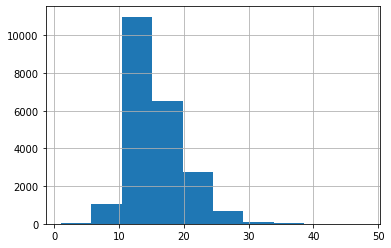

In [18]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 10)

In [19]:
max_seq_len = 100

In [20]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# Convert Integer Sequences to Tensors

In [21]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [22]:
print(len(train_y))

22260


In [23]:
print(len(df.label.unique()))

895


# Create DataLoaders

In [24]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 690 #int(max(df.label.unique()))

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

+
# Freeze BERT Parameters

In [25]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

# Define Model Architecture

In [26]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,int(max(df.label))+1) #int(max(df.label.unique())))

      #softmax activation function
      #self.softmax = nn.LogSoftmax(dim=1)
      self.tanh1 = nn.Tanh()
      self.ff2 = nn.Linear(int(max(df.label))+1,1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask,return_dict=False)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      # x = self.softmax(x)

      x = self.tanh1(x)
      x = self.ff2(x)
      return x

In [27]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [28]:
from transformers.utils.dummy_pt_objects import Adafactor
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = Adafactor(model.parameters(), lr = 1e-3)

# Find Class Weights

In [40]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight(class_weight = None, classes= np.unique(df.label),y= train_labels)

In [39]:
class_wts = np.ones(2)

In [31]:
print(len(class_wts))

2


In [32]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
# cross_entropy  = nn.NLLLoss(weight=weights)

cross_entropy  = torch.nn.L1Loss()

# number of training epochs
epochs = 10

# Fine-Tune BERT

In [41]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    # print("preds",preds.shape)
    # print("labels",labels.shape)
    labels = labels.to(device,dtype=torch.long)
    # preds = preds.to(device,dtype=torch.long)
    loss = cross_entropy(preds, labels)
    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [34]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)
      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)
      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

# Start Model Training

In [38]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:88: UserWarning: Using a target size (torch.Size([690])) that is different to the input size (torch.Size([690, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


RuntimeError: ignored

# Load Saved Model

In [ ]:
#load weights of best model
path1 = 'saved_weights.pt'
model.load_state_dict(torch.load(path1))

In [ ]:
train_losses=[]
valid_losses=[]

In [ ]:
!pip install torch

In [37]:
#!pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


# Get Predictions for Test Data

In [48]:
# get predictions for test data
import torch
torch.cuda.empty_cache()
import gc

gc.collect()

torch.cuda.empty_cache()
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

RuntimeError: ignored

In [ ]:
!nvidia-smi

In [ ]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    # corr = np.corrcoef(forecast, actual)[0,1]   # corr
    # mins = np.amin(np.hstack([forecast[:,None], 
    #                           actual[:,None]]), axis=1)
    # maxs = np.amax(np.hstack([forecast[:,None], 
    #                           actual[:,None]]), axis=1)
    # minmax = 1 - np.mean(mins/maxs)             # minmax
    # acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse})



In [ ]:
len(test_y)

In [ ]:
len(preds)

In [ ]:
# model's performance
# preds = np.argmax(preds, axis = 1)
print(forecast_accuracy(test_y.numpy(), preds))

# if isLocation:
#   print("City/Location")
  
# else:
#   print("group_name")

print(path)

In [ ]:
# confusion matrix
# pd.crosstab(test_y, preds)